In [1]:
import os
import sys
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
dev_train_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_device.xlsx')
train_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_train.xlsx')
test_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_test.xlsx')

dev_only_x = dev_train_df[['Time (min)', 'Temp (C)']]
dev_only_y = dev_train_df[['PCE', 'VocL', 'Jsc', 'FF']]
x_train = train_df[['Anneal_time', 'Anneal_temp', 'MajorAL_avg', 'MinorAL_avg',
                       'Ecc_avg', 'Orient_avg', 'Perim_avg']]
y_train = train_df[['PCE', 'VocL', 'Jsc', 'FF']]
x_test = test_df[['Anneal_time', 'Anneal_temp', 'MajorAL_avg', 'MinorAL_avg',
                       'Ecc_avg', 'Orient_avg', 'Perim_avg']]
y_test = test_df[['PCE', 'VocL', 'Jsc', 'FF']]

After loading in the data and splitting it into our training and testing datasets, it's time for some curve fitting and hyper-parameter optimization. This notebook optimizes the LASSO fitting on the above datasets

First, we need to define some functions to train, optimize, and compare the LASSO regression results for predicting the 4 different OPV device parameters, PCE, V$_{OC}$, J$_{SC}$, and FF.

In [33]:
def round_up(n, decimals=1):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier


def round_down(n, decimals=1):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier


def plot_parity(labels, predictions):
    """
    This function calculates and plots the correlation values of labels and predictions.
    An $R^{2}$ coefficient is calculated from these and annotates the plot.
    """
    
    upper = round_up(max(max(labels), max(predictions)))
    lower = round_down(min(min(labels), min(predictions)))
    
    xlin = ylin = np.arange(upper, lower, 0.1)

    r2 = r2_score(labels, predictions)
    fig, ax = plt.subplots(figsize = (8,6))
    plt.scatter(labels, predictions)
    plt.plot(xlin, ylin, c = 'k')
    ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4))
    ax.set_xlim(lower, upper)
    ax.set_ylim(lower, upper)
    ax.set_xlabel("Predictions")
    ax.set_ylabel("Ground Truth")
    
    return fig, ax


def mean_absolute_accuracy(labels, predictions):
    """
    This is a function to calculate the % accuracy of a batch of labels and 
    predictions made by a model.
    """
    
    accuracies = []
    for x, y in zip(predictions, labels):
        accuracy = np.abs(((y - x) / y))
        accuracies.append(accuracy)
        
    mean_accuracy = sum(accuracies)/len(accuracies)
        
    return mean_accuracy

def LASSO(x_fit, y_fit, x_pred, y_labels, alpha):
    """
    This function fits sklearn's lasso to data and returns train and test MSE, the
    final predicted labels, and the losses and coefficients of fit.
    """
    lasso = linear_model.Lasso(alpha = alpha)
    lasso.fit(x_fit, y_fit)

    y_train_pred = lasso.predict(x_fit)
    y_test_pred = lasso.predict(x_pred)

    train_mse = mean_squared_error(y_fit, y_train_pred)
    test_mse = mean_squared_error(y_labels, y_test_pred)
    test_accuracy = mean_absolute_accuracy(y_labels, y_test_pred)
    
    coeffs = lasso.coef_
    
    return y_test_pred, train_mse, test_mse, test_accuracy, coeffs


def LASSO_alpha_opt(x_fit, y_fit, x_pred, y_labels, lower, upper):
    """
    This function calls LASSO across a range of alphas and returns the best performing
    alpha, its index, and all the losses, and coefficients for each alpha.
    """
    
    alphas = np.logspace(lower, upper, 100)
    coeffs = {}
    train_errors = []
    test_errors = []

    best_alphas = []
    best_errors = []
    accuracies = []

    for i, a in enumerate(alphas):
        y_test_pred, train_mse, test_mse, test_accuracy, coeff = LASSO(x_fit, y_fit, x_pred, y_labels, a)
        
        coeffs[i] = coeff
        train_errors.append(train_mse)
        test_errors.append(test_mse)
        accuracies.append(test_accuracy)
        
        if i > 1:
            if test_errors[-1] <= test_errors[-2]:
                best_alphas.append(a)
                best_errors.append(test_mse)
                
            else:
                pass
        else:
            best_alphas.append(a)
            best_errors.append(test_mse)

    best_error = min(best_errors)
    alpha_idx = best_errors.index(best_error)
    best_alpha = best_alphas[alpha_idx]

    return train_errors, test_errors, best_alpha, alpha_idx, accuracies


def OPV_LASSO(x_train, y_train, x_test, y_test):
    """
    This function fits and optimizes 4 different sklearn LASSO instances to predict 4
    different OPV device performances, given the input information about the devices.
    """
    #Separate the labels by category for each dataset
    pce_train = y_train['PCE']
    pce_test = y_test['PCE']
    voc_train = y_train['VocL']
    voc_test = y_test['VocL']
    jsc_train = y_train['Jsc']
    jsc_test = y_test['Jsc']
    ff_train = y_train['FF']
    ff_test = y_test['FF']
    
    #Fit LASSO with a range of alphas for performance metric
    lower = -10
    upper = 10
    
    alphas = np.logspace(lower, upper, 100)
    
    pce_trn_err, pce_tst_err, pce_alpha, pce_idx, pce_accs  = LASSO_alpha_opt(x_train, pce_train,
                                                                     x_test, pce_test,
                                                                     lower = lower,
                                                                     upper = upper)
    voc_trn_err, voc_tst_err, voc_alpha, voc_idx, voc_accs = LASSO_alpha_opt(x_train, voc_train,
                                                                    x_test, voc_test,
                                                                    lower = lower,
                                                                    upper = upper)
    jsc_trn_err, jsc_tst_err, jsc_alpha, jsc_idx, jsc_accs = LASSO_alpha_opt(x_train, jsc_train,
                                                                    x_test, jsc_test,
                                                                    lower = lower,
                                                                    upper = upper)
    ff_trn_err, ff_tst_err, ff_alpha, ff_idx, ff_accs = LASSO_alpha_opt(x_train, ff_train,
                                                                x_test, ff_test,
                                                                lower = lower,
                                                                upper = upper)
    total_trn_err = []
    total_tst_err = []
    for pce1, pce2, voc1, voc2, jsc1, jsc2, ff1, ff2 in zip(pce_trn_err, pce_tst_err,
                                                            voc_trn_err, voc_tst_err,
                                                            jsc_trn_err, jsc_tst_err,
                                                            ff_trn_err, ff_tst_err):
        
        total_trn_err.append((pce1 + voc1 + jsc1 + ff1))
        total_tst_err.append((pce2 + voc2 + jsc2 + ff2))
    
    
    fig, ax = plt.subplots(figsize = (12, 8))
    plt.plot(alphas, total_trn_err, c = 'k', marker = '|', label = 'total train')
    plt.plot(alphas, total_tst_err, c = 'k', marker = '>', label = 'total test')
    ax.set_ylabel('MSE')
    ax.set_xlabel('alpha')
    plt.legend(loc = 'best')
    ax.set_xscale('log')
    plt.show()
    
    fig, ax = plt.subplots(figsize = (12, 8))
    plt.plot(alphas, pce_trn_err, c = 'k', marker = '|', label = 'pce train')
    plt.plot(alphas, pce_tst_err, c = 'k', marker = '>', label = 'pce test')
    plt.plot(alphas, voc_trn_err, c = 'r', marker = '|', label = 'voc train')
    plt.plot(alphas, voc_tst_err, c = 'r', marker = '>', label = 'voc test')
    plt.plot(alphas, jsc_trn_err, c = 'b', marker = '|', label = 'jsc train')
    plt.plot(alphas, jsc_tst_err, c = 'b', marker = '>', label = 'jsc test')
    plt.plot(alphas, ff_trn_err, c = 'g', marker = '|', label = 'ff train')
    plt.plot(alphas, ff_tst_err, c = 'g', marker = '>', label = 'ff test')
    ax.set_ylabel('MSE')
    ax.set_xlabel('alpha')
    plt.legend(loc = 'best')
    ax.set_xscale('log')
    plt.show()
    
    avg_acc = []
    for pce, voc, jsc, ff in zip(pce_accs, voc_accs, jsc_accs, ff_accs):
        
        avg_acc.append(((pce + voc + jsc + ff)/4))
    
    fig, ax = plt.subplots(figsize = (12,8))
    plt.plot(alphas, avg_acc, c = 'k', marker = '>', label = 'mean acc')
    plt.scatter(alphas[avg_acc.index(min(avg_acc))], min(avg_acc))
    plt.plot(alphas, pce_accs, c = 'r', marker = '|', label = 'pce acc')
    plt.plot(alphas, voc_accs, c = 'g', marker = '|', label = 'voc acc')
    plt.plot(alphas, jsc_accs, c = 'b', marker = '|', label = 'jsc acc')
    plt.plot(alphas, ff_accs, c = 'cyan', marker = '|', label = 'ff acc')
    ax.set_ylabel('Average Absolute Percent Error (%)')
    ax.set_xlabel('alpha')
    plt.legend(loc = 'best')
    ax.set_xscale('log')
    plt.show()
    
    #For the best alpha for each LASSO, final fit and predict test labels
    pce_pred, pce_train_mse, pce_test_mse, pce_coeffs, pce_acc = LASSO(x_train, pce_train, x_test,
                                                              pce_test, pce_alpha)
    voc_pred, voc_train_mse, voc_test_mse, voc_coeffs, voc_acc = LASSO(x_train, voc_train, x_test,
                                                              voc_test, voc_alpha)
    jsc_pred, jsc_train_mse, jsc_test_mse, jsc_coeffs, jsc_acc = LASSO(x_train, jsc_train, x_test,
                                                              jsc_test, jsc_alpha)
    ff_pred, ff_train_mse, ff_test_mse, ff_coeffs, ff_acc = LASSO(x_train,ff_train, x_test,
                                                          ff_test, ff_alpha)
    
    fig, ax = plot_parity(pce_test, pce_pred)
    plt.title('PCE Parity')
    plt.show()
    
    fig, ax = plot_parity(voc_test, voc_pred)
    plt.title('Voc Parity')
    plt.show()
    
    fig, ax = plot_parity(jsc_test, jsc_pred)
    plt.title('Jsc Parity')
    plt.show()
    
    fig, ax = plot_parity(ff_test, ff_pred)
    plt.title('FF Parity')
    plt.show()
    
    
    OPV_LASSO_dict = {
        'pce' : [pce_pred, pce_train_mse, pce_test_mse, pce_coeffs, pce_accs],
        'voc' : [voc_pred, voc_train_mse, voc_test_mse, voc_coeffs, voc_accs],
        'jsc' : [jsc_pred, jsc_train_mse, jsc_test_mse, jsc_coeffs, jsc_accs],
        'ff' : [jsc_pred, jsc_train_mse, jsc_test_mse, jsc_coeffs, ff_accs]
    }
    
    return OPV_LASSO_dict



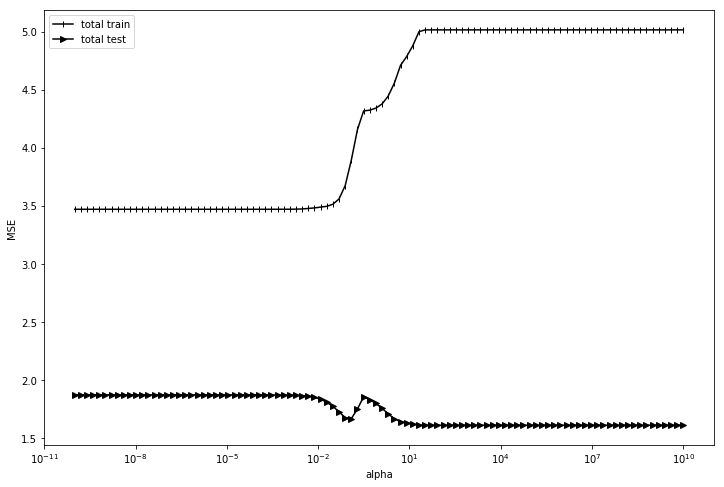

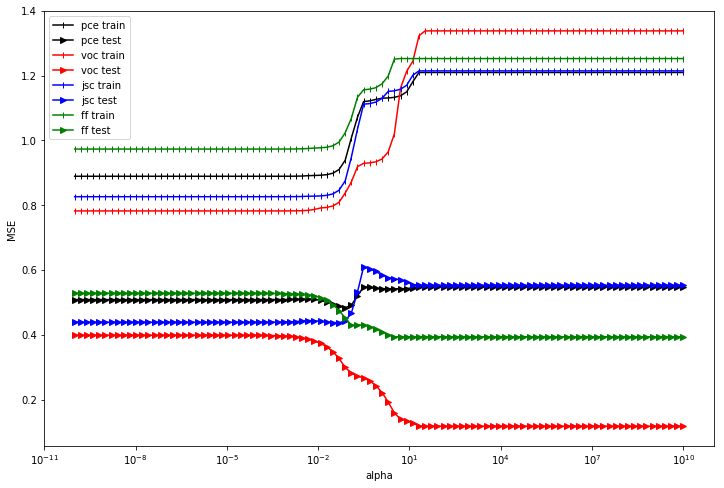

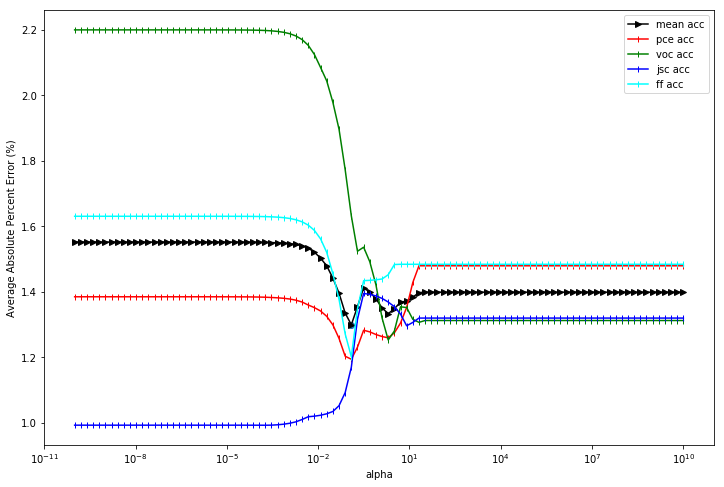

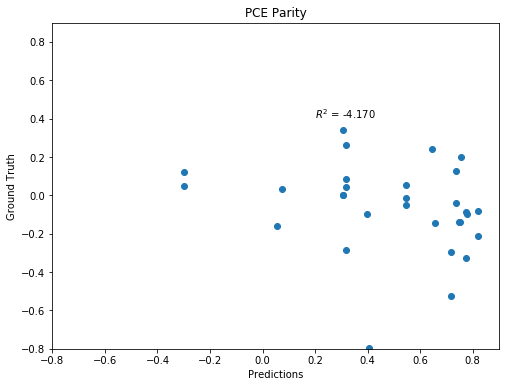

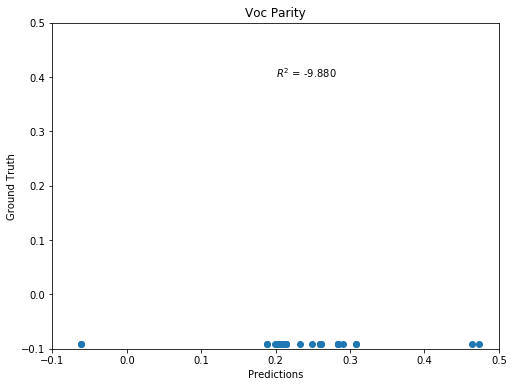

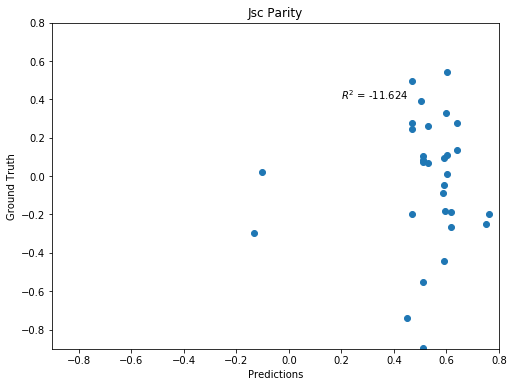

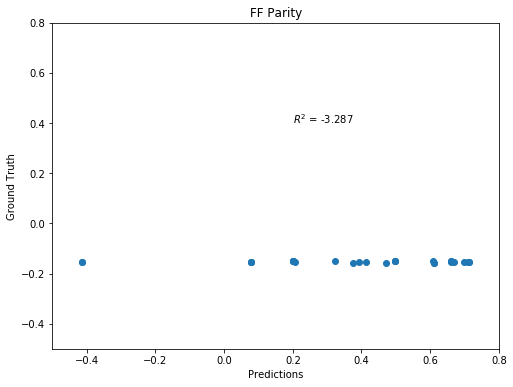

In [34]:
results = OPV_LASSO(x_train, y_train, x_test, y_test)

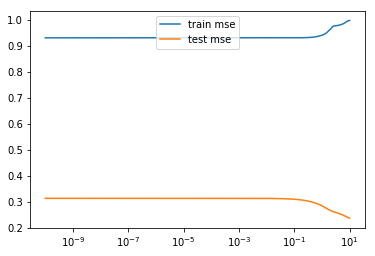

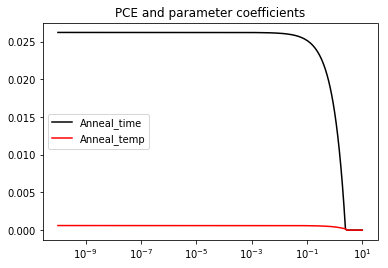

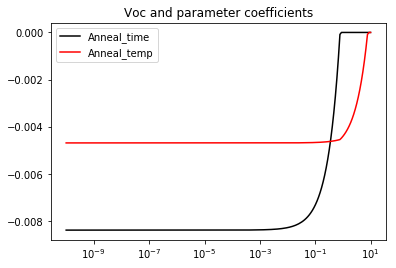

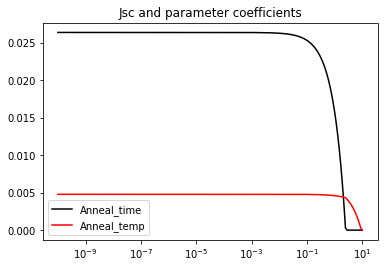

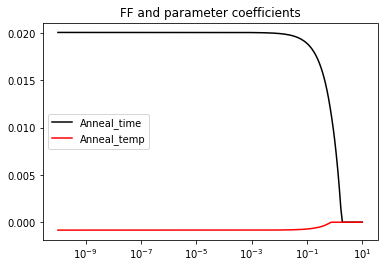

In [6]:
fig = plt.Figure(figsize = (12, 15))
plt.plot(alphas, train_errors, label = "train mse")
plt.plot(alphas, test_errors, label = 'test mse')
plt.legend(loc = 'upper center')
ax = plt.gca()
ax.set_xscale('log')
plt.show()
    
pce_co1 = []
pce_co2 = []

for k in coeffs.keys():
    pce_co1.append(coeffs[k][0][0])
    pce_co2.append(coeffs[k][0][1])
    
fig = plt.Figure(figsize = (30,20))
plt.plot(alphas, pce_co1, c = 'k', label = 'Anneal_time')
plt.plot(alphas, pce_co2, c = 'r', label = 'Anneal_temp')
plt.legend()
ax = plt.gca()
ax.set_xscale('log')
plt.title('PCE and parameter coefficients')
plt.show()

voc_co1 = []
voc_co2 = []

for k in coeffs.keys():
    voc_co1.append(coeffs[k][1][0])
    voc_co2.append(coeffs[k][1][1])
    
fig = plt.Figure(figsize = (30,20))
plt.plot(alphas, voc_co1, c = 'k', label = 'Anneal_time')
plt.plot(alphas, voc_co2, c = 'r', label = 'Anneal_temp')
plt.legend()
ax = plt.gca()
ax.set_xscale('log')
plt.title('Voc and parameter coefficients')
plt.show()

jsc_co1 = []
jsc_co2 = []

for k in coeffs.keys():
    jsc_co1.append(coeffs[k][2][0])
    jsc_co2.append(coeffs[k][2][1])
    
fig = plt.Figure(figsize = (30,20))
plt.plot(alphas, jsc_co1, c = 'k', label = 'Anneal_time')
plt.plot(alphas, jsc_co2, c = 'r', label = 'Anneal_temp')
plt.legend()
ax = plt.gca()
ax.set_xscale('log')
plt.title('Jsc and parameter coefficients')
plt.show()

ff_co1 = []
ff_co2 = []

for k in coeffs.keys():
    ff_co1.append(coeffs[k][3][0])
    ff_co2.append(coeffs[k][3][1])
    
fig = plt.Figure(figsize = (30,20))
plt.plot(alphas, ff_co1, c = 'k', label = 'Anneal_time')
plt.plot(alphas, ff_co2, c = 'r', label = 'Anneal_temp')
plt.legend()
ax = plt.gca()
ax.set_xscale('log')
plt.title('FF and parameter coefficients')
plt.show()

In [5]:
lasso = linear_model.Lasso(alpha = best_alpha)
lasso.fit(dev_only_x, dev_only_y)

preds = lasso.predict(x_test[['Anneal_time', 'Anneal_temp']])

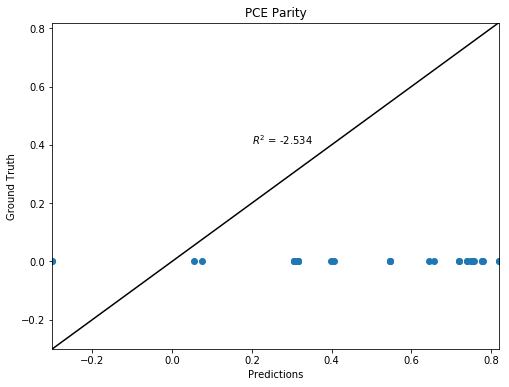

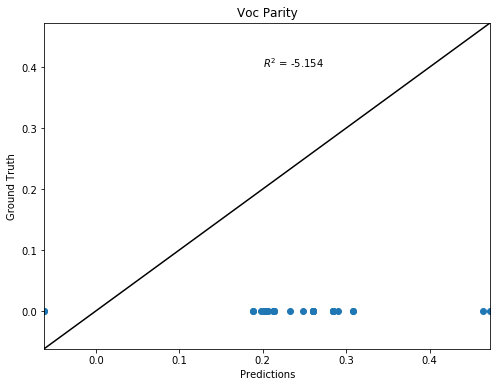

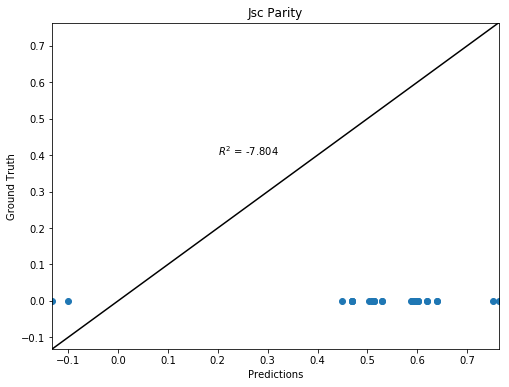

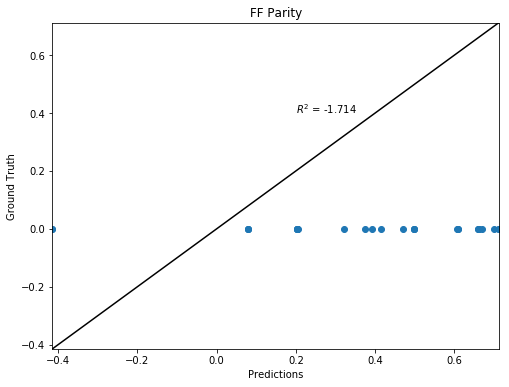

In [6]:
xlin = ylin = np.arange(-10, 10, 1)

r2 = r2_score(y_test['PCE'], preds[:,0])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['PCE'], preds[:,0])
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4))
ax.set_xlim(min(y_test['PCE'].min(), preds[:,0].min()), max(y_test['PCE'].max(), preds[:,0].max()))
ax.set_ylim(min(y_test['PCE'].min(), preds[:,0].min()), max(y_test['PCE'].max(), preds[:,0].max()))
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
plt.title('PCE Parity')
plt.show()

r2 = r2_score(y_test['VocL'], preds[:,1])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['VocL'], preds[:,1])
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4))
ax.set_xlim(min(y_test['VocL'].min(), preds[:,1].min()), max(y_test['VocL'].max(), preds[:,1].max()))
ax.set_ylim(min(y_test['VocL'].min(), preds[:,1].min()), max(y_test['VocL'].max(), preds[:,1].max()))
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
plt.title('Voc Parity')
plt.show()

r2 = r2_score(y_test['Jsc'], preds[:,2])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['Jsc'], preds[:,2])
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4))
ax.set_xlim(min(y_test['Jsc'].min(), preds[:,2].min()), max(y_test['Jsc'].max(), preds[:,2].max()))
ax.set_ylim(min(y_test['Jsc'].min(), preds[:,2].min()), max(y_test['Jsc'].max(), preds[:,2].max()))
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
plt.title('Jsc Parity')
plt.show()

r2 = r2_score(y_test['FF'], preds[:,3])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['FF'], preds[:,3])
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4))
ax.set_xlim(min(y_test['FF'].min(), preds[:,3].min()), max(y_test['FF'].max(), preds[:,3].max()))
ax.set_ylim(min(y_test['FF'].min(), preds[:,3].min()), max(y_test['FF'].max(), preds[:,3].max()))
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
plt.title('FF Parity')
plt.show()

In [7]:
alphas = np.logspace(-10, 1, 200)
coeffs = {}
train_errors = []
test_errors = []

best_alphas = []
best_errors = []

for i, a in enumerate(alphas):
    lasso = linear_model.Lasso(alpha = a)
    lasso.fit(x_train, y_train)

    y_train_pred = lasso.predict(x_train)
    y_test_pred = lasso.predict(x_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    coeffs[i]=lasso.coef_
    train_errors.append(train_mse)
    test_errors.append(test_mse)
    
    if i > 2:
        if test_errors[-1] < test_errors[-2]:
            best_alphas.append(a)
            best_errors.append(test_mse)
        else:
            pass
    else:
        pass

best_error = min(best_errors)
best_alpha_idx = best_errors.index(best_error)
best_alpha = best_alphas[best_alpha_idx]
print(best_alpha)
print(len(best_alphas))

10.0
188


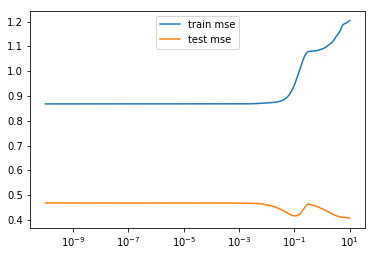

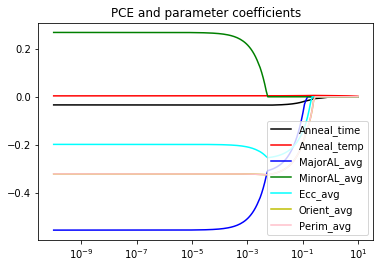

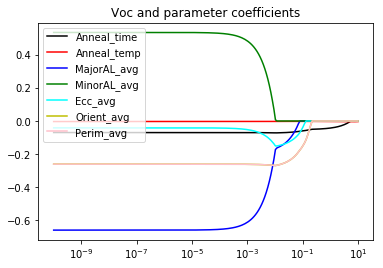

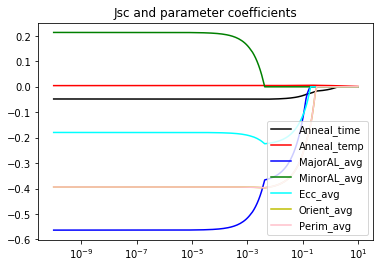

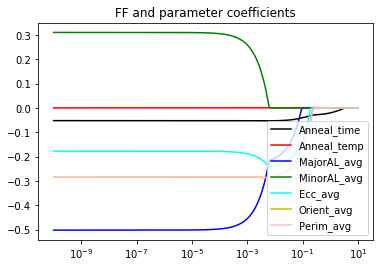

In [8]:
fig = plt.Figure(figsize = (12, 15))
plt.plot(alphas, train_errors, label = "train mse")
plt.plot(alphas, test_errors, label = 'test mse')
plt.legend(loc = 'upper center')
ax = plt.gca()
ax.set_xscale('log')
plt.show()
    
pce_co1 = []
pce_co2 = []
pce_co3 = []
pce_co4 = []
pce_co5 = []
pce_co6 = []
pce_co7 = []

for k in coeffs.keys():
    pce_co1.append(coeffs[k][0][0])
    pce_co2.append(coeffs[k][0][1])
    pce_co3.append(coeffs[k][0][2])
    pce_co4.append(coeffs[k][0][3])
    pce_co5.append(coeffs[k][0][4])
    pce_co6.append(coeffs[k][0][5])
    pce_co7.append(coeffs[k][0][6])
    
fig = plt.Figure(figsize = (30,20))
plt.plot(alphas, pce_co1, c = 'k', label = 'Anneal_time')
plt.plot(alphas, pce_co2, c = 'r', label = 'Anneal_temp')
plt.plot(alphas, pce_co3, c = 'b', label = 'MajorAL_avg')
plt.plot(alphas, pce_co4, c = 'g', label = 'MinorAL_avg')
plt.plot(alphas, pce_co5, c = 'cyan', label = 'Ecc_avg')
plt.plot(alphas, pce_co6, c = 'y', label = 'Orient_avg')
plt.plot(alphas, pce_co6, c = 'pink', label = 'Perim_avg')
plt.legend()
ax = plt.gca()
ax.set_xscale('log')
plt.title('PCE and parameter coefficients')
plt.show()

voc_co1 = []
voc_co2 = []
voc_co3 = []
voc_co4 = []
voc_co5 = []
voc_co6 = []
voc_co7 = []

for k in coeffs.keys():
    voc_co1.append(coeffs[k][1][0])
    voc_co2.append(coeffs[k][1][1])
    voc_co3.append(coeffs[k][1][2])
    voc_co4.append(coeffs[k][1][3])
    voc_co5.append(coeffs[k][1][4])
    voc_co6.append(coeffs[k][1][5])
    voc_co7.append(coeffs[k][1][6])
    
fig = plt.Figure(figsize = (30,20))
plt.plot(alphas, voc_co1, c = 'k', label = 'Anneal_time')
plt.plot(alphas, voc_co2, c = 'r', label = 'Anneal_temp')
plt.plot(alphas, voc_co3, c = 'b', label = 'MajorAL_avg')
plt.plot(alphas, voc_co4, c = 'g', label = 'MinorAL_avg')
plt.plot(alphas, voc_co5, c = 'cyan', label = 'Ecc_avg')
plt.plot(alphas, voc_co6, c = 'y', label = 'Orient_avg')
plt.plot(alphas, voc_co6, c = 'pink', label = 'Perim_avg')
plt.legend()
ax = plt.gca()
ax.set_xscale('log')
plt.title('Voc and parameter coefficients')
plt.show()

jsc_co1 = []
jsc_co2 = []
jsc_co3 = []
jsc_co4 = []
jsc_co5 = []
jsc_co6 = []
jsc_co7 = []

for k in coeffs.keys():
    jsc_co1.append(coeffs[k][2][0])
    jsc_co2.append(coeffs[k][2][1])
    jsc_co3.append(coeffs[k][2][2])
    jsc_co4.append(coeffs[k][2][3])
    jsc_co5.append(coeffs[k][2][4])
    jsc_co6.append(coeffs[k][2][5])
    jsc_co7.append(coeffs[k][2][6])
    
fig = plt.Figure(figsize = (30,20))
plt.plot(alphas, jsc_co1, c = 'k', label = 'Anneal_time')
plt.plot(alphas, jsc_co2, c = 'r', label = 'Anneal_temp')
plt.plot(alphas, jsc_co3, c = 'b', label = 'MajorAL_avg')
plt.plot(alphas, jsc_co4, c = 'g', label = 'MinorAL_avg')
plt.plot(alphas, jsc_co5, c = 'cyan', label = 'Ecc_avg')
plt.plot(alphas, jsc_co6, c = 'y', label = 'Orient_avg')
plt.plot(alphas, jsc_co6, c = 'pink', label = 'Perim_avg')
plt.legend()
ax = plt.gca()
ax.set_xscale('log')
plt.title('Jsc and parameter coefficients')
plt.show()

ff_co1 = []
ff_co2 = []
ff_co3 = []
ff_co4 = []
ff_co5 = []
ff_co6 = []
ff_co7 = []

for k in coeffs.keys():
    ff_co1.append(coeffs[k][3][0])
    ff_co2.append(coeffs[k][3][1])
    ff_co3.append(coeffs[k][3][2])
    ff_co4.append(coeffs[k][3][3])
    ff_co5.append(coeffs[k][3][4])
    ff_co6.append(coeffs[k][3][5])
    ff_co7.append(coeffs[k][3][6])
    
fig = plt.Figure(figsize = (30,20))
plt.plot(alphas, ff_co1, c = 'k', label = 'Anneal_time')
plt.plot(alphas, ff_co2, c = 'r', label = 'Anneal_temp')
plt.plot(alphas, ff_co3, c = 'b', label = 'MajorAL_avg')
plt.plot(alphas, ff_co4, c = 'g', label = 'MinorAL_avg')
plt.plot(alphas, ff_co5, c = 'cyan', label = 'Ecc_avg')
plt.plot(alphas, ff_co6, c = 'y', label = 'Orient_avg')
plt.plot(alphas, ff_co6, c = 'pink', label = 'Perim_avg')
plt.legend()
ax = plt.gca()
ax.set_xscale('log')
plt.title('FF and parameter coefficients')
plt.show()

In [11]:
lasso = linear_model.Lasso(alpha = best_alpha)
lasso.fit(x_train, y_train)

preds = lasso.predict(x_test)

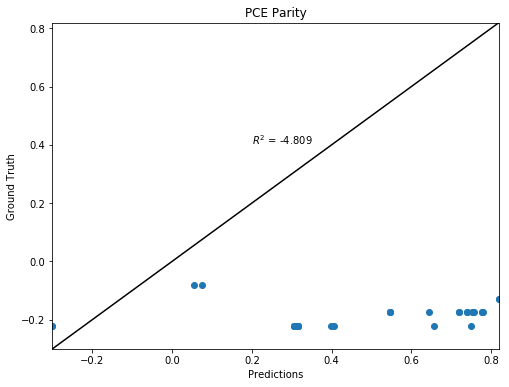

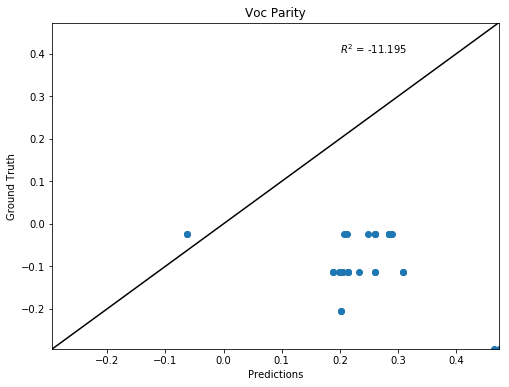

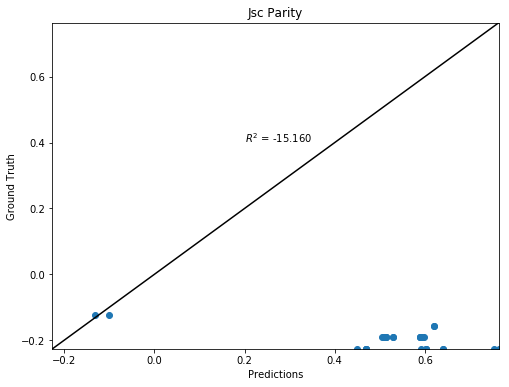

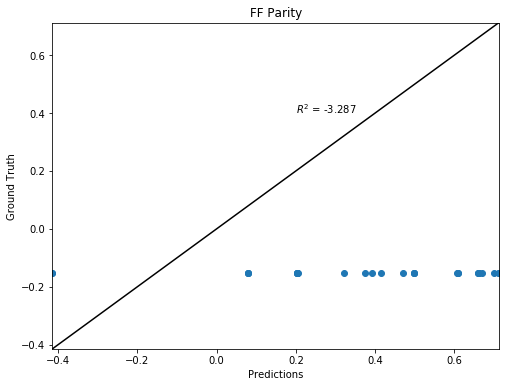

In [12]:
xlin = ylin = np.arange(-10, 10, 1)

r2 = r2_score(y_test['PCE'], preds[:,0])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['PCE'], preds[:,0])
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4))
ax.set_xlim(min(y_test['PCE'].min(), preds[:,0].min()), max(y_test['PCE'].max(), preds[:,0].max()))
ax.set_ylim(min(y_test['PCE'].min(), preds[:,0].min()), max(y_test['PCE'].max(), preds[:,0].max()))
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
plt.title('PCE Parity')
plt.show()

r2 = r2_score(y_test['VocL'], preds[:,1])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['VocL'], preds[:,1])
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4))
ax.set_xlim(min(y_test['VocL'].min(), preds[:,1].min()), max(y_test['VocL'].max(), preds[:,1].max()))
ax.set_ylim(min(y_test['VocL'].min(), preds[:,1].min()), max(y_test['VocL'].max(), preds[:,1].max()))
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
plt.title('Voc Parity')
plt.show()

r2 = r2_score(y_test['Jsc'], preds[:,2])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['Jsc'], preds[:,2])
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4))
ax.set_xlim(min(y_test['Jsc'].min(), preds[:,2].min()), max(y_test['Jsc'].max(), preds[:,2].max()))
ax.set_ylim(min(y_test['Jsc'].min(), preds[:,2].min()), max(y_test['Jsc'].max(), preds[:,2].max()))
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
plt.title('Jsc Parity')
plt.show()

r2 = r2_score(y_test['FF'], preds[:,3])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['FF'], preds[:,3])
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4))
ax.set_xlim(min(y_test['FF'].min(), preds[:,3].min()), max(y_test['FF'].max(), preds[:,3].max()))
ax.set_ylim(min(y_test['FF'].min(), preds[:,3].min()), max(y_test['FF'].max(), preds[:,3].max()))
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
plt.title('FF Parity')
plt.show()